# Demo Convolutional Neural Network (CNN) para procesar imágenes e identificar la clase que corresponde

1) Cargar librerías:

In [1]:
#@title Librerías a usar
import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Definir los parámetros:

In [2]:
## selección de los parámetros 

# 
#@markdown ### Parámetros de imágenes:
imagen_largo_ancho =  64#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
imagen_usar_generadas_data_augmentation = True #@param {type:"boolean"}

#@markdown ### Parámetros de la red:
cnn_tamaño_kernel =  3#@param {type:"integer"}
cnn_tamaño_pooling = 3 #@param {type:"integer"}
cnn_cantidad_capas_ocultas =  5#@param {type:"integer"}
cnn_agregar_capa_BatchNormalization = True #@param {type:"boolean"}
cnn_cantidad_neuronas_Dense =  "5" #@param {type:"string"}
cnn_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]
cnn_cant_epocas_entrenamiento =  350#@param {type:"integer"}


## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# tamaño de los kernels y pooling (para simplificar son todas iguales)
if cnn_tamaño_kernel<1:
  cnn_tamaño_kernel = 1
cnn_kernel_shape = (cnn_tamaño_kernel, cnn_tamaño_kernel)
if cnn_tamaño_pooling<1:
  cnn_tamaño_pooling=1
cnn_pooling_shape = (cnn_tamaño_pooling, cnn_tamaño_pooling)

# indica la configuración para la parte Encoder 
#   (cada elemento de las listas son la configuración de las capas Conv)
#cnn_filters = [ 128, 64, 32, 16, 8 ] 
if cnn_cantidad_capas_ocultas<1:
  cnn_cantidad_capas_ocultas = 1
cnn_filters = []
for i in range(cnn_cantidad_capas_ocultas, 0, -1):
  cnn_filters.append( 2**(i+2) )

# define tamaño de capa densa previa a la de salida
num_Dense_out = []
for val in cnn_cantidad_neuronas_Dense.split(","):
  num_Dense_out.append( int(val) )
if len(num_Dense_out)<1:
   num_Dense_out.append( 8 )
#num_Dense_out = (8 if cnn_cantidad_neuronas_Dense<1 else cnn_cantidad_neuronas_Dense)

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (cnn_tipo_capa_salida[:7] == 'softmax')

# cantidad de épocas del entrenamiento
cantEpocas = (100 if cnn_cant_epocas_entrenamiento<1 else cnn_cant_epocas_entrenamiento)

print("Configuración de la CNN definida: ")
print ("     -Tamaño Imagen: ", IMAGE_SHAPE)
print ("     -Kernels + Pooling: [", cnn_kernel_shape, "+", cnn_pooling_shape, "] ")
print ("     -Capas: [ ", IMAGE_SHAPE, ", Conv", cnn_filters, (", BatchNormalization" if  cnn_agregar_capa_BatchNormalization else "" ), ", FLATTEN, Dense[", num_Dense_out, "], ", ("Softmax" if tipo_output_softMax else "Dense[1] "))

Configuración de la CNN definida: 
     -Tamaño Imagen:  (64, 64, 3)
     -Kernels + Pooling: [ (3, 3) + (3, 3) ] 
     -Capas: [  (64, 64, 3) , Conv [128, 64, 32, 16, 8] , BatchNormalization , FLATTEN, Dense[ [5] ],  Softmax


3) Montar el Drive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/IRIS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

> Para Entrenamiento: 
- Clases cargadas:  57
- Imágenes cargadas:  57
- Ejemplo  versicolor   (64, 64, 3) : 


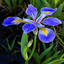



> Para Prueba: 
- Clases cargadas:  33
- Imágenes cargadas:  33
- Ejemplo  virginica   (64, 64, 3) : 


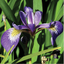

In [4]:
#@title Cargar imágenes
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (57, 64, 64, 3)
 - y_trainEnc (cant):  57


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (33, 64, 64, 3)
 - y_testEnc (cant):  33


> Para Ambos: 
 - dictMapeo:  {'setosa': 0, 'versicolor': 1, 'virginica': 2}
 - clases_map:  ['setosa', 'versicolor', 'virginica']

 - Imagen reconstruida de  versicolor ( 1  /  [0. 1. 0.] )


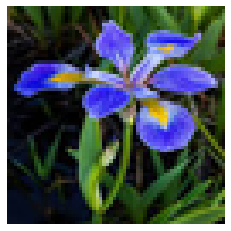

In [5]:
#@title Preparar imágenes
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))  
  return auxiAr
  
# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
if tipo_output_softMax:
  print(" - y_trainEnc (cant): ", len(y_trainEnc))
else:
  print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
if tipo_output_softMax:
  print(" - y_testEnc (cant): ", len(y_testEnc))
else:
  print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

5) Establecer el modelo para la CNN:

Modelo CNN creado con  15  capas:
Model: "ConvNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
c_conv_1 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
p_conv_1 (MaxPooling2D)      (None, 22, 22, 128)       0         
_________________________________________________________________
c_conv_2 (Conv2D)            (None, 22, 22, 64)        73792     
_________________________________________________________________
p_conv_2 (MaxPooling2D)      (None, 8, 8, 64)          0         
_________________________________________________________________
c_conv_3 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
p_conv_3 (MaxPooling2D)  

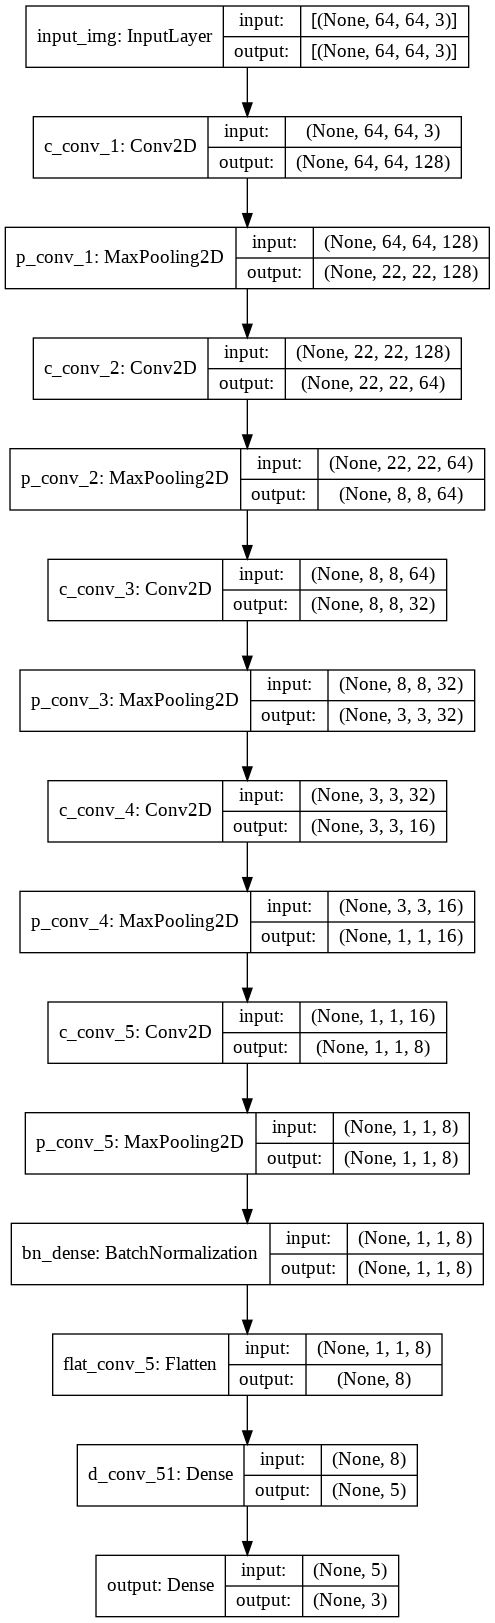

In [6]:
#@title Establecer modelo

# define la arquitectura de capas de la CNN
# teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=IMAGE_SHAPE, name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'conv_'
for i in range(len(cnn_filters)):  

    # define el nombre de la capa oculta
    auxlayerName = 'conv_'+str(i+1)

    # agrega las capas ocultas de tipo Conv2D + MaxPooling 
    eachLay = Conv2D(cnn_filters[i], cnn_kernel_shape, activation='relu', padding='same', name='c_'+auxlayerName)(eachLay) 
    eachLay = MaxPooling2D(cnn_pooling_shape, padding='same', name='p_'+auxlayerName)(eachLay)

if cnn_agregar_capa_BatchNormalization:
  # nota: para convNet no se usa DropOut, conviene usar BatchNormalization
  eachLay = BatchNormalization(name='bn_dense')(eachLay)

#  agrega capa Flatten y Dense 
eachLay = Flatten(name='flat_'+auxlayerName)(eachLay)

iDense = 1
for cantDense in num_Dense_out:
  eachLay = Dense(cantDense, activation='relu', name='d_'+auxlayerName+str(iDense))(eachLay)
  iDense = iDense + 1

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = Dense(units = len(dictMapeo), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = Dense(1, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
model = Model(input_img_Lay, output_img_Lay, name='ConvNet')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print("Modelo CNN creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)

6) Entrenar el modelo de la RNA:

In [7]:
#@title Entrenar

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=[] ) 

print("\n>Entrenamiento Finalizado.")



> De los  57 ejemplos de entrenamiento: 
            se usan  51 ejemplos para entrenar 
            y  6 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/350
2/2 [==============================] - 3s 653ms/step - loss: 1.0461 - accuracy: 0.4902 - val_loss: 1.0920 - val_accuracy: 0.3333
Epoch 2/350
2/2 [==============================] - 0s 37ms/step - loss: 0.9846 - accuracy: 0.4118 - val_loss: 1.0836 - val_accuracy: 0.3333
Epoch 3/350
2/2 [==============================] - 0s 40ms/step - loss: 0.9454 - accuracy: 0.5294 - val_loss: 1.0749 - val_accuracy: 0.3333
Epoch 4/350
2/2 [==============================] - 0s 37ms/step - loss: 0.8563 - accuracy: 0.5882 - val_loss: 1.0696 - val_accuracy: 0.3333
Epoch 5/350
2/2 [==============================] - 0s 38ms/step - loss: 0.7910 - accuracy: 0.6863 - val_loss: 1.0702 - val_accuracy: 0.3333
Epoch 6/350
2/2 [==============================] - 0s 36ms/step - loss: 0.7332 - accuracy: 0.7647 - val_loss: 1.0724 - val_accuracy: 0.3333

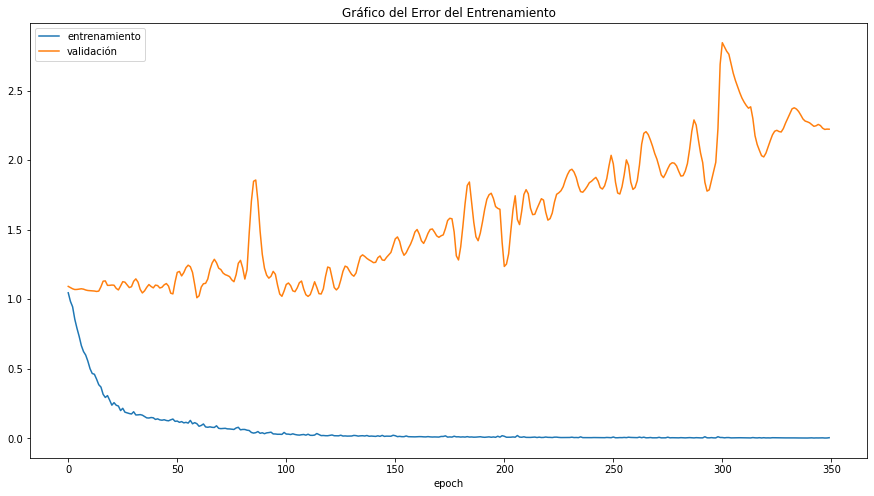

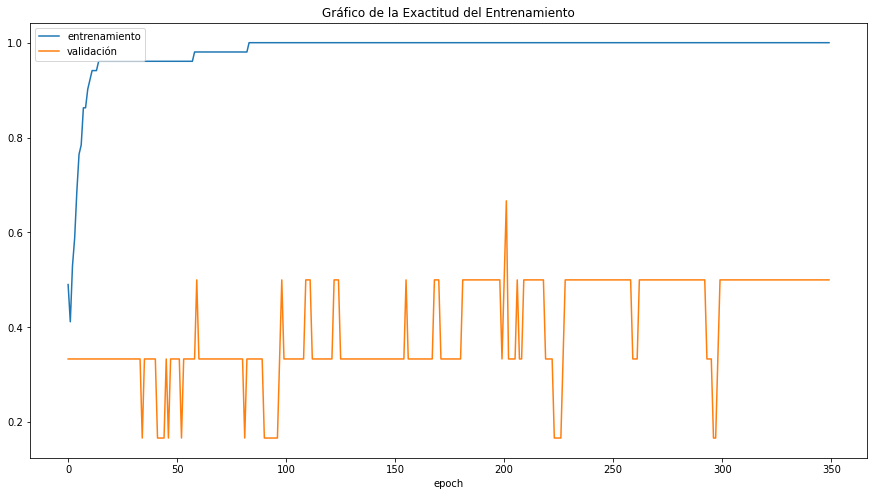

In [8]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [11]:
#@title Probar red entrenada con datos de entrenamiento
mostrar_detalle_imagenes_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostrarImagenes=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        if mostrarImagenes:

          # sólo muestra las imágenes no generadas por DA
          strTitulo = 'Real: ' + clReal + ' / RNA: ' 
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )
          
          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    if mostrarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_imagenes_entrenamiento)

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      setosa       1.00      0.95      0.97        19
  versicolor       0.90      1.00      0.95        19
   virginica       0.94      0.89      0.92        19

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57


Matriz de Confusión: 
              p:setosa  p:versicolor  p:virginica
r:setosa            18             0            1
r:versicolor         0            19            0
r:virginica          0             2           17



>Resultados: 


7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

In [14]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_imagenes_prueba = False #@param {type:"boolean"}

 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map, mostrar_detalle_imagenes_prueba)

2/2 [==============================] - 0s 9ms/step - loss: 0.4123 - accuracy: 0.8182

>Evaluación del Modelo: 
    - Error:  0.41230762004852295
    - Exactitud:  81.81818127632141




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      setosa       0.89      0.73      0.80        11
  versicolor       0.71      0.91      0.80        11
   virginica       0.90      0.82      0.86        11

    accuracy                           0.82        33
   macro avg       0.83      0.82      0.82        33
weighted avg       0.83      0.82      0.82        33


Matriz de Confusión: 
              p:setosa  p:versicolor  p:virginica
r:setosa             8             2            1
r:versicolor         1            10            0
r:virginica          0             2            9



>Resultados: 
